# CV Project - Week 2 Submission

###  Group #1 - Muhammad Hussain Habib (27100016) & Ayaan Ahmed (27100155) 

This notebook demonstrates a two-view reconstruction pipeline that first uses Week #1's code to match features between two images then finds the essential matrix and then decomposes it to find the camera pose then triangulates those points to generate a point cloud.

You can find the link to our dataset here: https://drive.google.com/drive/folders/1DVKbLRkWLxdu-5qB_ANK54H9rlfK7fGI?usp=drive_link

*Note: As promised, dataset has been expanded to include a whole room*.

<br><br>


### **Step #1 - Imports**

In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

### **Step #2 - Preprocessing, Feature Detection and Matching (from Week #1)**

Using our pipeline from Week #1, we first preprocess our images and compute and match features using SIFT. We selected two images which had large enough overlap, provided rich texture (for finding features easily) and had good parallax (camera was moved not just rotated).

Loaded frame_276.png: 2160x3840 -> 2160x3840
Loaded frame_277.png: 2160x3840 -> 2160x3840
Keypoints detected: 72750 in image 1, 63416 in image 2
Raw matches: 72750
Good matches (after Lowe's ratio test): 19924


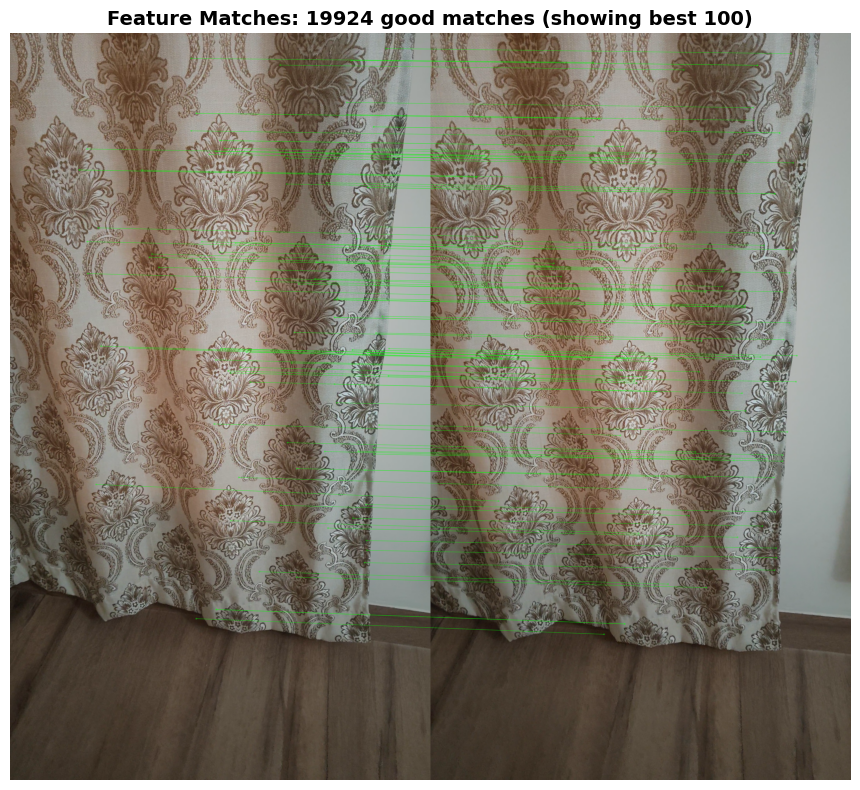

In [130]:
def load_and_resize_image(image_path, max_dimension=1920):
    img = cv2.imread(image_path)
    
    height, width = img.shape[:2]
    scale = max_dimension / max(height, width)
    new_width = int(width)
    new_height = int(height)
    img_resized = img
    
    print(f"Loaded {Path(image_path).name}: {width}x{height} -> {new_width}x{new_height}")
    return img_resized, new_width, new_height

# selected two images that not only had rotation but also translation
IMAGE_1_IDX = 276
IMAGE_2_IDX = 277

frames_dir = "extracted_frames/"
img1_path = os.path.join(frames_dir, f"frame_{IMAGE_1_IDX:03d}.png")
img2_path = os.path.join(frames_dir, f"frame_{IMAGE_2_IDX:03d}.png")

img1, width1, height1 = load_and_resize_image(img1_path)
img2, width2, height2 = load_and_resize_image(img2_path)

def detect_and_match_features(img1, img2, ratio_thresh=0.75):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # detecting and computing SIFT features
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(gray1, None)
    kp2, desc2 = sift.detectAndCompute(gray2, None)
    
    print(f"Keypoints detected: {len(kp1)} in image 1, {len(kp2)} in image 2")
    
    # matching features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(desc1, desc2, k=2)
    
    # applying Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    print(f"Raw matches: {len(matches)}")
    print(f"Good matches (after Lowe's ratio test): {len(good_matches)}")
    
    return kp1, kp2, desc1, desc2, good_matches

kp1, kp2, desc1, desc2, good_matches = detect_and_match_features(img1, img2)

num_display = 100
good_matches_sorted = sorted(good_matches, key=lambda x: x.distance)
display_matches = good_matches_sorted[:num_display]

match_img = cv2.drawMatches(
    img1, kp1, img2, kp2, display_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0)
)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title(f'Feature Matches: {len(good_matches)} good matches (showing best {num_display})', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### **Step #3 - Estimating Essential Matrix**

The Essential Matrix (E) encodes the geometric relationship between two calibrated cameras and it contains information about the relative rotation and translation between the camera poses. To estimate E, we need:

1. Camera intrinsic matrix K
2. Matched 2D points from both images (found using Week #1 pipeline)
3. RANSAC to robustly filter out outlier matches (as it iteratively finds the Essential matrix that best fits the majority of matches (inliers),
while ignoring incorrect matches)

The intrinsic matrix K is constructed by assuming:
- Principal point (cx, cy) is at the image center
- Focal lengths fx = fy = image width

Camera Intrinsic Matrix K:
[[2.16e+03 0.00e+00 1.08e+03]
 [0.00e+00 2.16e+03 1.92e+03]
 [0.00e+00 0.00e+00 1.00e+00]]
  
Inliers: 14200/19924 (71.3%)
Essential Matrix E:
[[ 0.00878023 -0.53415069 -0.12147302]
 [ 0.55864737  0.00621618  0.41916227]
 [ 0.12219352 -0.44370203 -0.01499885]]


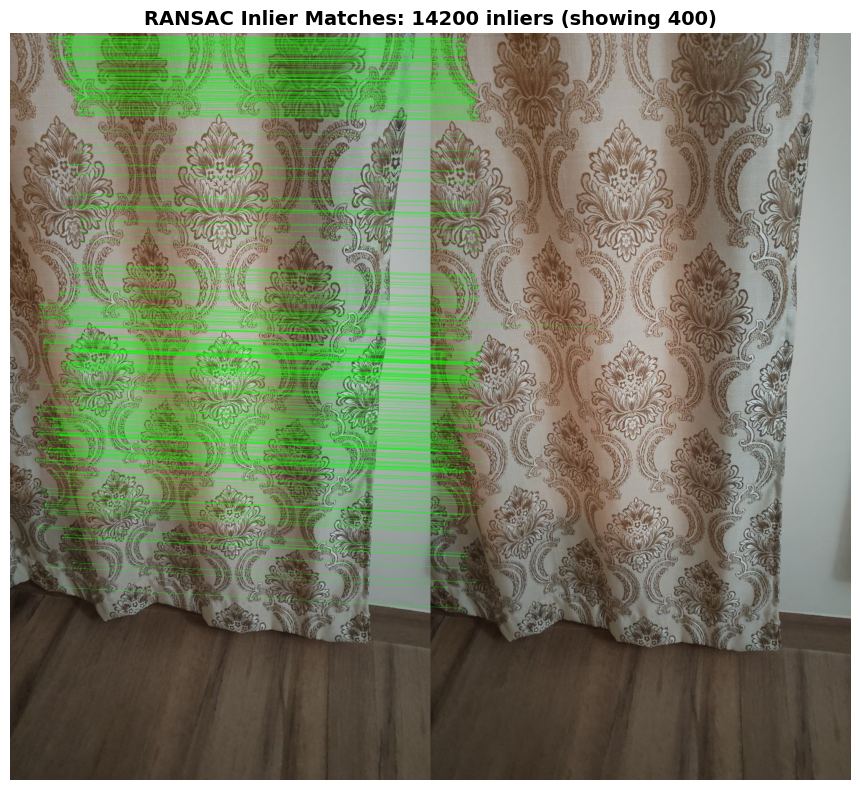

In [131]:
def construct_intrinsic_matrix(image_width, image_height):
    # assuming principal point is at image center and focal length is image width:
    fx = fy = image_width
    cx = image_width / 2.0
    cy = image_height / 2.0
    
    K = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ], dtype=np.float64)
    
    return K


def estimate_essential_matrix(kp1, kp2, matches, K):
    # extracting matched point coordinates
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # estimating essential matrix
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    # count the inliers
    inliers = mask.ravel().tolist()
    num_inliers = sum(inliers)
    
    print(f"  \nInliers: {num_inliers}/{len(matches)} ({100*num_inliers/len(matches):.1f}%)")
    
    return E, mask, pts1, pts2


K = construct_intrinsic_matrix(width1, height1)
print("Camera Intrinsic Matrix K:")
print(K)

E, mask, pts1, pts2 = estimate_essential_matrix(kp1, kp2, good_matches, K)
print("Essential Matrix E:")
print(E)

# visualizing inlier matches
inlier_matches = [m for m, inlier in zip(good_matches, mask.ravel()) if inlier]
inlier_match_img = cv2.drawMatches(
    img1, kp1, img2, kp2, inlier_matches[:400], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0)
)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(inlier_match_img, cv2.COLOR_BGR2RGB))
plt.title(f'RANSAC Inlier Matches: {len(inlier_matches)} inliers (showing 400)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### **Step #4 - Recovering Camera Pose**

The Essential matrix can be decomposed into 4 possible solutions for [R|t] (rotation and translation). However, only one of these solutions is physically valid: the one where reconstructed 3D points appear in front of both cameras.

cv2.recoverPose() automatically performs this "cheirality check" by:
1. Decomposing E into 4 candidate [R|t] solutions
2. Triangulating a few points for each candidate
3. Checking which solution places most points in front of both cameras
4. Returning the correct R and t

This is essential because we need to know which solution represents the actual camera motion. The cheirality check ensures we get the geometrically valid pose that can be used for triangulation.

In [132]:
def recover_pose_and_triangulate(E, pts1, pts2, K, mask):
    num_inliers, R, t, pose_mask = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
    
    print(f"Camera pose recovered successfully")
    print(f"Points in front of both cameras: {num_inliers}")
    
    return R, t, pose_mask

R, t, pose_mask = recover_pose_and_triangulate(E, pts1, pts2, K, mask)

print("\nRotation Matrix R:")
print(R)
print("\nTranslation Vector t:")
print(t)

Camera pose recovered successfully
Points in front of both cameras: 12781

Rotation Matrix R:
[[ 0.99832275  0.02794114 -0.05070488]
 [-0.02690341  0.9994167   0.02103472]
 [ 0.05126304 -0.01963531  0.99849214]]

Translation Vector t:
[[ 0.63221871]
 [ 0.15606064]
 [-0.75891012]]


### **Step #5 - Triangulating 3D Points**

Triangulation is the process of computing 3D point positions from their 2D projections in multiple images. Given:
- Two camera projection matrices P1 = K[I|0] and P2 = K[R|t]
- Corresponding 2D points in both images

Camera 1 is assumed to be at the origin with identity rotation [I|0].

Camera 2 is positioned relative to Camera 1 using the recovered [R|t].

In [133]:
def triangulate_points(pts1, pts2, K, R, t, mask):

    # camera projection matrices:
    # assuming camera 1 is at origin: P1 = K[I|0]
    P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])

    # camera 2: P2 = K[R|t]
    P2 = K @ np.hstack([R, t])
    
    # filtering points by mask
    pts1_inliers = pts1[mask.ravel() == 1]
    pts2_inliers = pts2[mask.ravel() == 1]
    
    # triangulating points
    points_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)
    
    # converting from homogeneous to 3D coordinates
    points_3d = points_hom[:3] / points_hom[3]
    points_3d = points_3d.T
    
    print(f"  Triangulated {points_3d.shape[0]} 3D points")
    
    return points_3d, pts1_inliers, P1, P2

points_3d, pts1_inliers, P1, P2 = triangulate_points(pts1, pts2, K, R, t, pose_mask)

  Triangulated 12781 3D points


### **Step #6 - Postprocessing**

To create a visually meaningful point cloud, we extract the RGB color of each 3D point from the original image. For each triangulated point, we:
1. Find its corresponding 2D location in image 1
2. Sample the pixel color at that location
3. Associate that color with the 3D point

The PLY (Polygon File Format) is a simple format for storing 3D data. It contains:
- A header describing the data structure
- Vertex data (x, y, z coordinates and r, g, b colors)

In [134]:
def extract_colors(img, points_2d):
    # extracting RGB colors for 3D points from the first image
    colors = []
    for pt in points_2d:
        x, y = int(pt[0]), int(pt[1])

        # since openCV uses BGR, convert to RGB
        bgr = img[y, x]
        rgb = bgr[::-1] 
        colors.append(rgb)
    return np.array(colors, dtype=np.uint8)

def save_ply(filename, points, colors):
    # saving 3D points and colors to .ply file
    with open(filename, 'w') as f:
        # Write PLY header
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        for point, color in zip(points, colors):
            f.write(f"{point[0]} {point[1]} {point[2]} {color[0]} {color[1]} {color[2]}\n")
    
    print(f"Saved point cloud to: {filename}")

colors = extract_colors(img1, pts1_inliers)
print(f"Extracted colors for {len(colors)} points")

output_filename = "pair_reconstructed.ply"
save_ply(output_filename, points_3d, colors)

Extracted colors for 12781 points
Saved point cloud to: pair_reconstructed.ply


### **Step #7 - Visualization**

Finally, we visualize the reconstructed 3D point cloud to verify our pipeline worked correctly. The visualization shows 3D points colored according to their appearance in the original image and their spatial distribution of points in the scene.

X range: [-21.59, 17.04]
Y range: [-19.21, 20.28]
Z range: [1.59, 50.00]


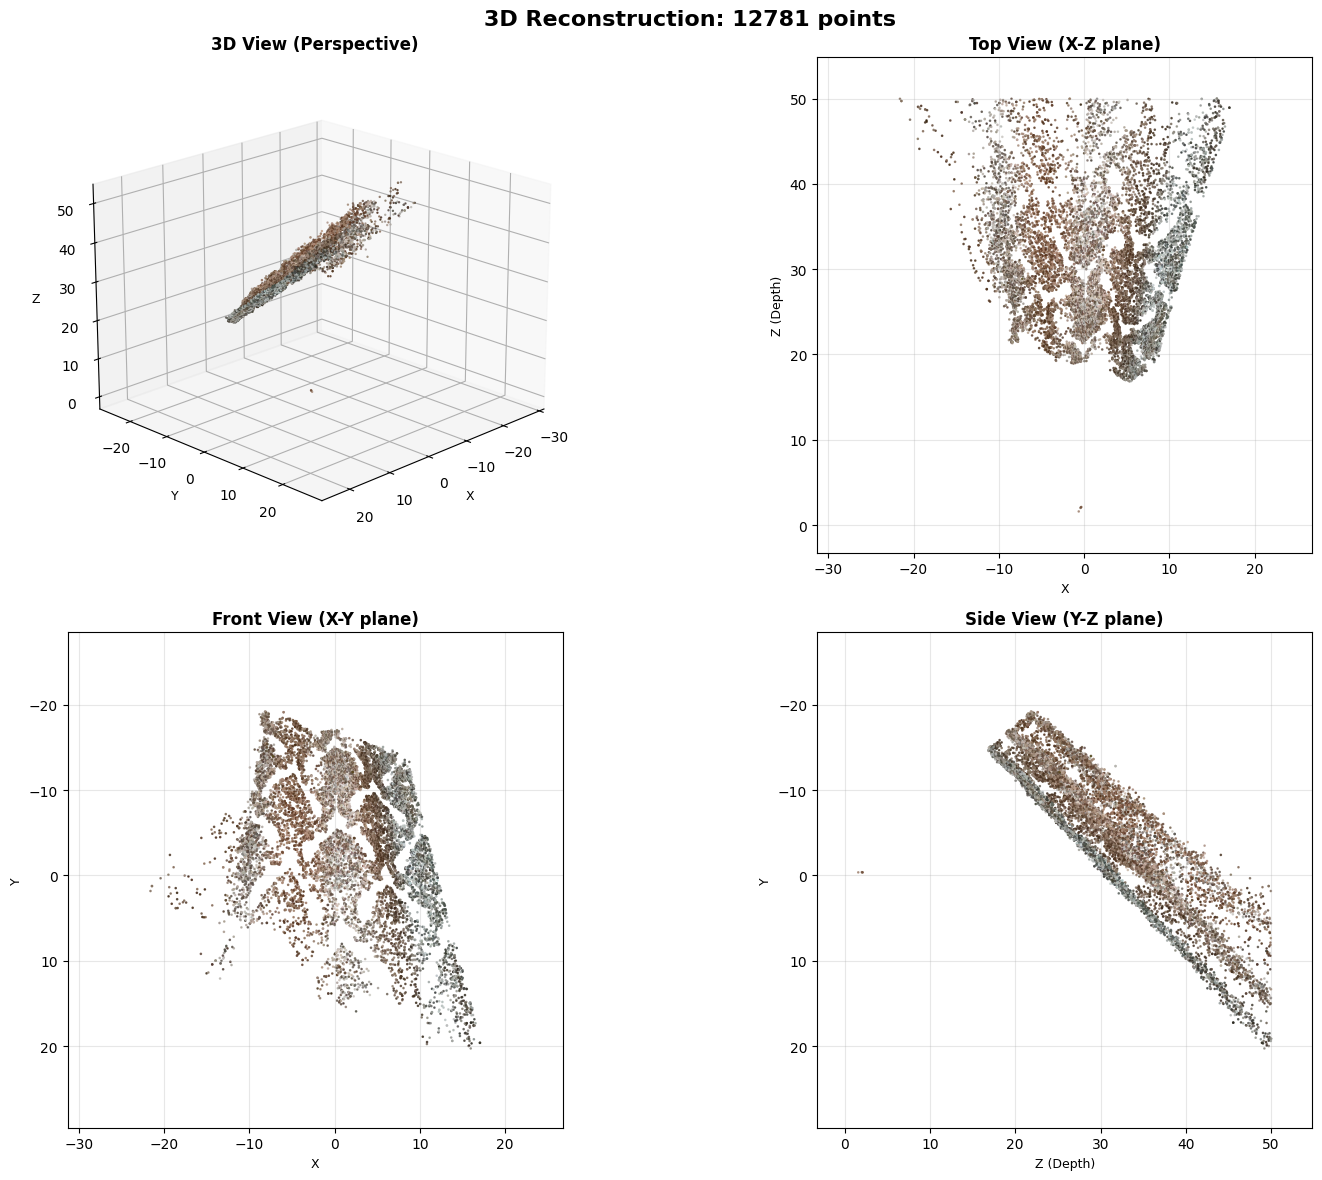

In [135]:
print(f"X range: [{points_3d[:, 0].min():.2f}, {points_3d[:, 0].max():.2f}]")
print(f"Y range: [{points_3d[:, 1].min():.2f}, {points_3d[:, 1].max():.2f}]")
print(f"Z range: [{points_3d[:, 2].min():.2f}, {points_3d[:, 2].max():.2f}]")

# calculating midpoint and range for limits
mid_x = (points_3d[:, 0].max() + points_3d[:, 0].min()) * 0.5
mid_y = (points_3d[:, 1].max() + points_3d[:, 1].min()) * 0.5
mid_z = (points_3d[:, 2].max() + points_3d[:, 2].min()) * 0.5

scale_factor = 0.6
max_range = np.array([
    points_3d[:, 0].max() - points_3d[:, 0].min(),
    points_3d[:, 1].max() - points_3d[:, 1].min(),
    points_3d[:, 2].max() - points_3d[:, 2].min()
]).max() * scale_factor

fig = plt.figure(figsize=(16, 12))

# 3D View (top-left)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
            c=colors/255.0, marker='.', s=2, alpha=0.8)
ax1.set_xlabel('X', fontsize=9)
ax1.set_ylabel('Y', fontsize=9)
ax1.set_zlabel('Z', fontsize=9)
ax1.set_title('3D View (Perspective)', fontsize=12, fontweight='bold')
ax1.set_xlim(mid_x - max_range, mid_x + max_range)
ax1.set_ylim(mid_y - max_range, mid_y + max_range)
ax1.set_zlim(mid_z - max_range, mid_z + max_range)
ax1.view_init(elev=20, azim=45)

# Top view (X-Z plane, looking down Y-axis)
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(points_3d[:, 0], points_3d[:, 2], 
            c=colors/255.0, marker='.', s=3, alpha=0.8)
ax2.set_xlabel('X', fontsize=9)
ax2.set_ylabel('Z (Depth)', fontsize=9)
ax2.set_title('Top View (X-Z plane)', fontsize=12, fontweight='bold')
ax2.set_xlim(mid_x - max_range, mid_x + max_range)
ax2.set_ylim(mid_z - max_range, mid_z + max_range)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Front view (X-Y plane, looking along Z-axis)
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(points_3d[:, 0], points_3d[:, 1], 
            c=colors/255.0, marker='.', s=3, alpha=0.8)
ax3.set_xlabel('X', fontsize=9)
ax3.set_ylabel('Y', fontsize=9)
ax3.set_title('Front View (X-Y plane)', fontsize=12, fontweight='bold')
ax3.set_xlim(mid_x - max_range, mid_x + max_range)
ax3.set_ylim(mid_y - max_range, mid_y + max_range)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()  # Invert Y to match camera convention (Y down)

# Side view (Y-Z plane, looking along X-axis)
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(points_3d[:, 2], points_3d[:, 1], 
            c=colors/255.0, marker='.', s=3, alpha=0.8)
ax4.set_xlabel('Z (Depth)', fontsize=9)
ax4.set_ylabel('Y', fontsize=9)
ax4.set_title('Side View (Y-Z plane)', fontsize=12, fontweight='bold')
ax4.set_xlim(mid_z - max_range, mid_z + max_range)
ax4.set_ylim(mid_y - max_range, mid_y + max_range)
ax4.set_aspect('equal')
ax4.grid(True, alpha=0.3)
ax4.invert_yaxis()  # Invert Y to match camera convention

plt.suptitle(f'3D Reconstruction: {len(points_3d)} points', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()